In [54]:
import sys
sys.path.append("..")

In [55]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
pyro.set_rng_seed(42)

In [56]:
x1 = torch.rand(100, 1) * 2.0 - 1.2
x2 = torch.rand(0, 1) * 0.4 + 2.2
x = torch.cat([x1, x2])
sigma = 0.10
noise = torch.normal(mean=torch.full_like(x, 0.), std=sigma)
y = x.mul(1.5).add(0.2).sin().mul(1.5) + noise

x_test = torch.linspace(-6, 6, 401).unsqueeze(-1)

y_test = x_test.mul(1.5).add(0.2).sin().mul(1.5)

In [57]:
x.shape, y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [58]:
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))

In [59]:
x1, y1 = next(iter(loader))

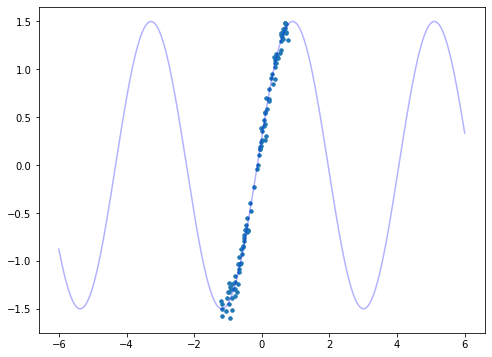

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)

In [61]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
optim = torch.optim.Adam(net.parameters(), 1e-4)
for _ in range(20000):
    optim.zero_grad()
    net(x).sub(y).pow(2).mean().backward()
    optim.step()

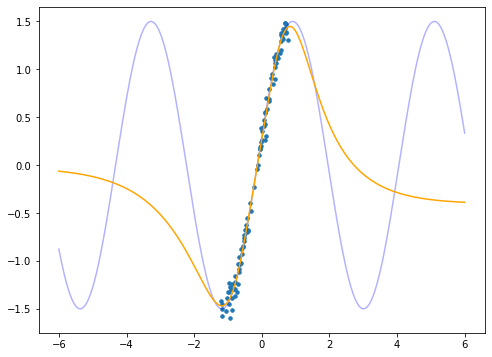

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, net(x_test).detach(), color="orange")


In [73]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))

In [74]:
prior = tyxe.priors.IIDPrior(dist.Normal(0, 3))

In [75]:
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.05)

In [76]:
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=1)

In [77]:
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)

In [78]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    if i % 1000 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 20000, callback)

epoch: 0 | elbo: 1377292.25
epoch: 1000 | elbo: 267394.4375
epoch: 2000 | elbo: 69219.078125
epoch: 3000 | elbo: 31558.03515625
epoch: 4000 | elbo: 18497.375
epoch: 5000 | elbo: 8682.5830078125
epoch: 6000 | elbo: 5584.14599609375
epoch: 7000 | elbo: 2929.14697265625
epoch: 8000 | elbo: 1659.7515869140625
epoch: 9000 | elbo: 1371.2275390625
epoch: 10000 | elbo: 957.0538330078125
epoch: 11000 | elbo: 651.1190185546875
epoch: 12000 | elbo: 662.3727416992188
epoch: 13000 | elbo: 561.4112548828125
epoch: 14000 | elbo: 478.525146484375
epoch: 15000 | elbo: 455.4813537597656
epoch: 16000 | elbo: 474.206298828125
epoch: 17000 | elbo: 477.4176025390625
epoch: 18000 | elbo: 435.0486145019531
epoch: 19000 | elbo: 403.0789794921875


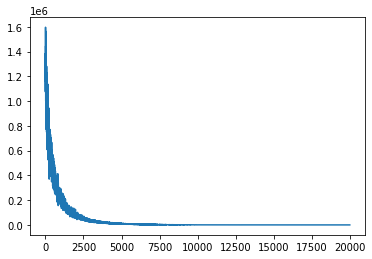

In [79]:
plt.plot(elbos)

In [83]:
#with tyxe.poutine.local_reparameterization():
m, sd = bnn.predict(x_test, num_predictions=50)
m, sd = m.detach(), sd.detach()


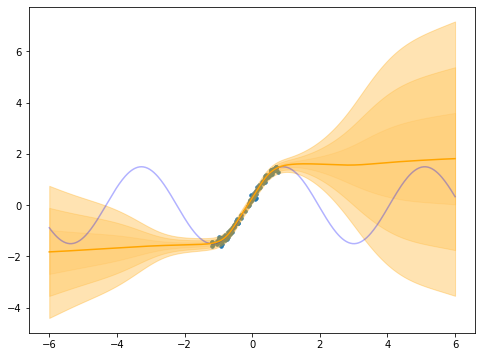

In [84]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, m.detach(), color="orange")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="orange")

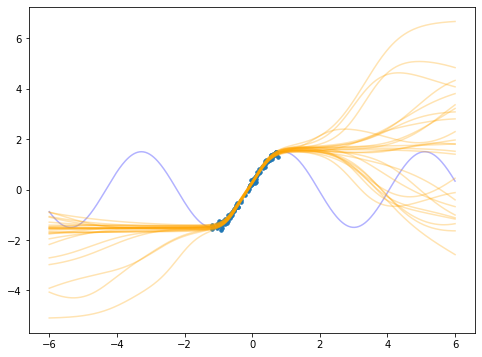

In [85]:

sampled_predictions = bnn.predict(x_test, num_predictions=25, aggregate=False)

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
for yhat in sampled_predictions:
    plt.plot(x_test, yhat, color="orange", alpha=0.3)

In [86]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=PyroParam(torch.tensor(0.05), constraint=dist.constraints.positive))
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)

In [87]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    if i % 1000 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 20000, callback)

epoch: 0 | elbo: 12846.6337890625
epoch: 1000 | elbo: 598.1043090820312
epoch: 2000 | elbo: 441.80755615234375
epoch: 3000 | elbo: 359.2122497558594
epoch: 4000 | elbo: 294.85040283203125
epoch: 5000 | elbo: 258.37164306640625
epoch: 6000 | elbo: 221.4713134765625
epoch: 7000 | elbo: 178.15118408203125
epoch: 8000 | elbo: 156.97305297851562
epoch: 9000 | elbo: 156.00547790527344
epoch: 10000 | elbo: 137.96368408203125
epoch: 11000 | elbo: 127.02293395996094
epoch: 12000 | elbo: 128.71719360351562
epoch: 13000 | elbo: 123.69793701171875
epoch: 14000 | elbo: 121.44214630126953
epoch: 15000 | elbo: 127.18718719482422
epoch: 16000 | elbo: 120.23384857177734
epoch: 17000 | elbo: 123.46361541748047
epoch: 18000 | elbo: 121.94425964355469
epoch: 19000 | elbo: 125.10433959960938


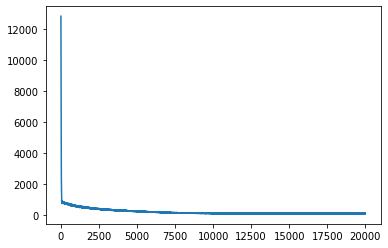

In [88]:
plt.plot(elbos)

In [89]:
m, sd = bnn.predict(x_test, num_predictions=50)
m, sd = m.detach(), sd.detach()

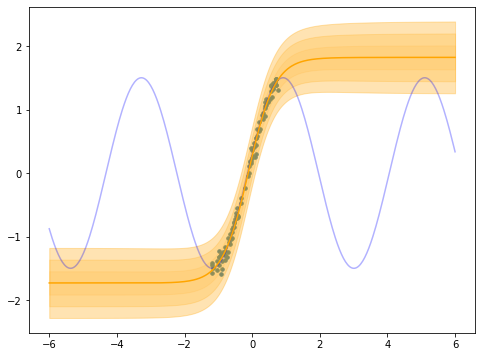

In [90]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, m.detach(), color="orange")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="orange")